In [1]:
import datetime as dt # useful handling of dates and times
import numpy as np 
import pandas as pd # spreadsheet type data handling and visualization, also 
                    # has some SQL-like features but they are awkwardly implemented
import glob 
from salishsea_tools import geo_tools
import os
import pytz # for handling timezones
import matplotlib.pyplot as plt 
import cmocean as cmo # nice color maps
# sqlalchemy interfaces between SQL databases and python with a syntax that I found relatively easy to adapt to...
from sqlalchemy import create_engine, case, MetaData
from sqlalchemy.orm import create_session, aliased
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func

# a bunch of tools contributed to by past and present members of Susan's research group:
from salishsea_tools import evaltools as et

In [2]:
# This sets up an interface with the SQLite database I sent you- change the path to the location on your system:
dbpath='/ocean/shared/SalishSeaCastData/DFO/BOT/' # include ending /
dbname='DFO_OcProfDB.sqlite'
engine = create_engine('sqlite:///' + dbpath+dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [3]:
# get metadata so you can see some information about the tables loaded above
md=MetaData()
md.reflect(engine)

In [4]:
# list the fields present in the relevant tables:
print('Columns in StationTBL:')
print(sorted([x.name for x in md.tables['StationTBL'].columns]))
print('Columns in ObsTBL:')
print(sorted([x.name for x in md.tables['ObsTBL'].columns]))
# note: the fields in CalcsTBL were calculated from values in ObsTBL and were not present in the original data
print('Columns in CalcsTBL:')
print(sorted([x.name for x in md.tables['CalcsTBL'].columns]))

Columns in StationTBL:
['AGENCY', 'COUNTRY', 'DATA DESCRIPTION', 'EVENT NUMBER', 'ID', 'LATITUDE', 'LONGITUDE', 'Lat', 'Lon', 'MISSION', 'PLATFORM', 'PROJECT', 'SCIENTIST', 'START TIME', 'STATION', 'StartDay', 'StartHour', 'StartMonth', 'StartTimeZone', 'StartYear', 'WATER DEPTH', 'WDIR', 'WSPD', 'sourceFile']
Columns in ObsTBL:
['Ammonia', 'Ammonia_units', 'Ammonium', 'Ammonium_units', 'Carbon_Dissolved_Organic', 'Carbon_Dissolved_Organic_units', 'Carbon_Particulate_Organic', 'Carbon_Particulate_Organic_units', 'Carbon_Particulate_Total', 'Carbon_Particulate_Total_units', 'Chlorophyll_Extracted', 'Chlorophyll_Extracted_gt0point7um', 'Chlorophyll_Extracted_gt0point7um_units', 'Chlorophyll_Extracted_gt5point0um', 'Chlorophyll_Extracted_gt5point0um_units', 'Chlorophyll_Extracted_units', 'Chlorophyll_plus_PhaeoPigment_Extracted', 'Chlorophyll_plus_PhaeoPigment_Extracted_units', 'Date', 'Date_units', 'Depth', 'Depth_Nominal', 'Depth_Nominal_units', 'Depth_units', 'Flag_Ammonium', 'Flag_Car

In [5]:
# Here is a trick for combining fields that represent basically the same thing but have different names:
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
# also get the temperature units that go with those measurements to check they make sense
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)],
              else_=ObsTBL.Temperature_Reversing_units)))

In [6]:
# write a query. SQLAlchemy will not execute the query until you ask for the results
# A very simple query asks for values from a single table. return all pressure, depth, and nitrate_plus_nitrite values 
# from ObsTBL where Nitrate_plusNitrite is greater than or equal to zero
qry1=session.query(ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Nitrate_plus_Nitrite).filter(ObsTBL.Nitrate_plus_Nitrite>=0)

In [7]:
# now return the results of that query as a pandas dataframe 
df1=pd.DataFrame(qry1.all())

In [8]:
# display the first 6 rows of the dataframe:
df1.head(6)

,Pressure,Depth,Nitrate_plus_Nitrite
0,NaN,12.0,6.6
1,NaN,21.5,21.2
2,NaN,30.5,23.5
3,NaN,52.3,28.0
4,NaN,75.4,26.5
5,NaN,99.6,26.1


In [9]:
# Every row in StationTBL is linked to several corresponding rows in ObsTBL. 
# StationTBLID is the 'Foreign Key' that links the rows in ObsTBL to rows in StationTBL by 
# matching StationTBLID in StationTBL with the primary key of StationTBL (ID)
# to query fields from both tables, they have to be joined like this:
# This query will find all Lat/Lon combinations where Lat > 50 that have Nitrate_plus_Nitrite data.
# \ is line contination
#qry2=session.query(StationTBL.Lat,StationTBL.Lon).\    # choose which fields you want to return
#        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\      # join the two tables on the appropriate field
#        filter(and_(StationTBL.Lat>50,ObsTBL.Nitrate_plus_Nitrite>=0)).\           # choose records matching certain criteria
#        group_by(StationTBL.Lat,StationTBL.Lon)                                   # only return unique lat/Lon combinations
#df2=pd.DataFrame(qry2.all())  # return as pandas dataframe

In [10]:
qry2=session.query(StationTBL.Lat,StationTBL.Lon).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        filter(and_(StationTBL.Lat>50,ObsTBL.Nitrate_plus_Nitrite>=0)).\
        group_by(StationTBL.Lat,StationTBL.Lon)
df2=pd.DataFrame(qry2.all())

In [11]:
df2.head()

,Lat,Lon
0,50.000167,-128.011000
1,50.000167,-128.000667
2,50.000167,-127.999500
3,50.000333,-128.005167
4,50.000500,-128.004000


Text(0, 0.5, 'Lat')

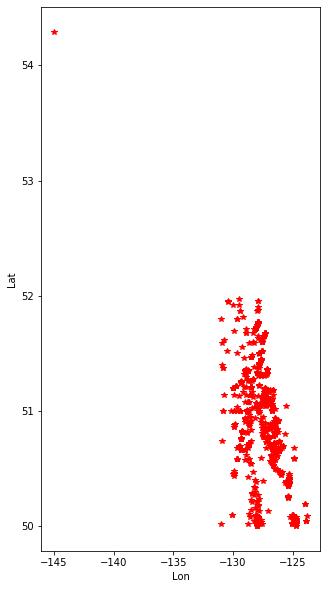

In [12]:
# plot those lats and lons to show you got only lat>50
fig,ax=plt.subplots(1,1,figsize=(5,10))
ax.plot(df2['Lon'],df2['Lat'],'r*')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

In [13]:
# use function from evaltools (loaded as et) to load DFO nutrient data automatically:
# pick date range from Jan 1 2015 to Feb 15 2015 and exclude Saanich Inlet data:
df=et.loadDFO(basedir=dbpath,dbname=dbname,
              datelims=(dt.datetime(2015,1,1),dt.datetime(2015,2,15)),excludeSaanich=True)
df

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.859421,1.884,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.777243,6.54434,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.771987,6.6435,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.439995,10.9071,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.433733,10.9071,2015-02-11 11:04:07
5,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,21.6,None,None,None,NaN,mg/m^3,25.24,42.60,umol/L,31.068364,8.948580,21.4171,2015-02-11 11:04:07
6,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,21.6,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,31.079015,8.944286,21.4171,2015-02-11 11:04:07
7,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,30.7,None,None,None,0.42,mg/m^3,25.69,42.87,umol/L,31.275767,8.884897,30.4393,2015-02-11 11:04:07
8,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,30.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,31.282097,8.883087,30.4393,2015-02-11 11:04:07
9,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,41.4,None,None,None,NaN,mg/m^3,25.68,42.49,umol/L,31.406059,8.861600,41.0474,2015-02-11 11:04:07
